In [ ]:
#all_slow

# Tutorial: Fine-Tuning Sequence Classification on DataFrames with IMDB
> Tuning a Sequence Classification model on the IMDB dataset

## Introduction

In this tutorial we will be showing an end-to-end example of fine-tuning a Transformer for sequence classification on a custom dataset in `DataFrame` format.

By the end of this you should be able to:

1. Build a dataset with the `SequenceClassificationDatasets` class, and their DataLoaders
2. Build a `SequenceClassificationTuner` quickly, find a good learning rate, and train with the One-Cycle Policy
3. Save that model away, to be used with deployment or other HuggingFace libraries
4. Apply inference using both the `Tuner` available function as well as with the `EasySequenceClassifier` class within AdaptNLP

## Installing the Library

This tutorial utilizies the latest AdaptNLP version, as well as parts of the `fastai` library. Please run the below code to install them:

In [ ]:
# !pip install adaptnlp -U

In [ ]:
#hide
from nbverbose.showdoc import *

## Getting the Dataset

First we need a dataset. We will use the `fastai` library to download the `IMDB_SAMPLE` dataset, a subset of IMDB Movie Reviews.

In [ ]:
from fastai.data.external import URLs, untar_data

`URLs` holds a namespace of many data endpoints, and `untar_data` is a function that can download and extract any data from a given URL.

Combining both, we can download the data:

In [ ]:
data_path = untar_data(URLs.IMDB_SAMPLE)

If we look at what was downloaded, we will find a `texts.csv` file:

In [ ]:
data_path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

This is our data we want to use. We should now open the `csv` in `pandas` to generate our `DataFrame` object:

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(data_path/'texts.csv')

Let's look at our data

In [ ]:
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


We will find that there is a `label`, some `text`, and a `is_valid` boolean, which determines if a row is part of the training or the validation set

Now that we've downloaded some data, let's pick a viable model to train with

## Picking a Model with the Hub

AdaptNLP has a `HFModelHub` class that allows you to communicate with the HuggingFace Hub and pick a model from it, as well as a namespace `HF_TASKS` class with a list of valid tasks we can search by.

Let's try and find one suitable for sequence classification.

First we need to import the class and generate an instance of it:

In [ ]:
from adaptnlp import HFModelHub, HF_TASKS

In [ ]:
hub = HFModelHub()

Next we can search for a model:

In [ ]:
models = hub.search_model_by_task(HF_TASKS.TEXT_CLASSIFICATION)

Let's look at a few:

In [ ]:
models[:10]

[Model Name: distilbert-base-uncased-finetuned-sst-2-english, Tasks: [text-classification],
 Model Name: roberta-base-openai-detector, Tasks: [text-classification],
 Model Name: roberta-large-mnli, Tasks: [text-classification],
 Model Name: roberta-large-openai-detector, Tasks: [text-classification]]

These are models specifically tagged with the `text-classification` tag, so you may not see a few models you would expect such as `bert_base_cased`.

We'll use that first model, `distilbert-base-uncased`:

In [ ]:
model = models[0]

In [ ]:
model

Model Name: distilbert-base-uncased-finetuned-sst-2-english, Tasks: [text-classification]

Now that we have picked a model, let's use the data API to prepare our data

> Note: It should be mentioned that this is optional, you can always just pass in the string name of a model such as "bert-base-cased"

## Building `TaskDatasets` with `SequenceClassificationDatasets`

Each task has a high-level data wrapper around the `TaskDatasets` class. In our case this is the `SequenceClassificationDatasets` class:

In [ ]:
from adaptnlp import SequenceClassificationDatasets

There are multiple different constructors for the `SequenceClassificationDatasets` class, and you should never call the main constructor directly.

We will be using `from_dfs`:

In [ ]:
from adaptnlp import SequenceClassificationDatasets
show_doc(SequenceClassificationDatasets.from_dfs)

<h4 id="SequenceClassificationDatasets.from_dfs" class="doc_header"><code>SequenceClassificationDatasets.from_dfs</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L57" class="source_link" style="float:right">[source]</a></h4>

> <code>SequenceClassificationDatasets.from_dfs</code>(**`train_df`**:`DataFrame`, **`text_col`**:`str`, **`label_col`**:`str`, **`tokenizer_name`**:`str`, **`tokenize`**:`bool`=*`True`*, **`is_multicategory`**:`bool`=*`False`*, **`label_delim`**=*`' '`*, **`valid_df`**=*`None`*, **`split_func`**=*`None`*, **`split_pct`**=*`0.2`*, **`tokenize_kwargs`**:`dict`=*`{}`*, **`auto_kwargs`**:`dict`=*`{}`*)

Builds [`SequenceClassificationDatasets`](/adaptnlp/training.sequence_classification.html#SequenceClassificationDatasets) from a `DataFrame` or set of `DataFrames`

**Parameters:**


 - **`train_df`** : *`<class 'pandas.core.frame.DataFrame'>`*	<p>A training dataframe</p>


 - **`text_col`** : *`<class 'str'>`*	<p>The name of the text column</p>


 - **`label_col`** : *`<class 'str'>`*	<p>The name of the label column</p>


 - **`tokenizer_name`** : *`<class 'str'>`*	<p>The name of the tokenizer</p>


 - **`tokenize`** : *`<class 'bool'>`*, *optional*	<p>Whether to tokenize immediatly</p>


 - **`is_multicategory`** : *`<class 'bool'>`*, *optional*	<p>Whether each item has a single label or multiple labels</p>


 - **`label_delim`** : *`<class 'str'>`*, *optional*	<p>If `is_multicategory`, how to separate the labels</p>


 - **`valid_df`** : *`<class 'NoneType'>`*, *optional*	<p>An optional validation dataframe</p>


 - **`split_func`** : *`<class 'NoneType'>`*, *optional*	<p>Optionally a splitting function similar to RandomSplitter</p>


 - **`split_pct`** : *`<class 'float'>`*, *optional*	<p>What % to split the train_df</p>


 - **`tokenize_kwargs`** : *`<class 'dict'>`*, *optional*	<p>kwargs for the tokenize function</p>


 - **`auto_kwargs`** : *`<class 'dict'>`*, *optional*	<p>kwargs for the AutoTokenizer.from_pretrained constructor</p>



Anything you would normally pass to the tokenizer call (such as `max_length`, `padding`) should go in `tokenize_kwargs`, and anything going to the `AutoTokenizer.from_pretrained` constructor should be passed to the `auto_kwargs`.

In our case we only have a `train_df`, we want to split based on a column, and we have a tokenizer name.

First we'll write a basic function that takes in our `DataFrame`, and returns two lists of train_idxs, and valid_idxs

In [ ]:
def get_y(items:pd.DataFrame):
    idxs = (items["is_valid"].values.astype('bool'))
    train_idxs, valid_idxs = [], []
    for i,idx in enumerate(idxs):
        train_idxs.append(i) if idx else valid_idxs.append(i)
    return (train_idxs, valid_idxs)

Next we'll build our `SequenceClassificationDatasets`:

In [ ]:
dsets = SequenceClassificationDatasets.from_dfs(
    df,
    text_col='text',
    label_col='label',
    tokenizer_name=model.name,
    tokenize=True,
    split_func=get_y,
    tokenize_kwargs={'max_length':128, 'truncation':True, 'padding':True}
)

> Note: If you have a training and validation `DataFrame`, simply pass in the validation `DataFrame` as `valid_df=validation_dataframe` and do not pass in any `split_func` or `split_pct`. Everything else is the exact same

And finally turn it into some `AdaptiveDataLoaders`.

These are just fastai's `DataLoaders` class, but it overrides a few functions to have it work nicely with HuggingFace's `Dataset` class

In [ ]:
show_doc(SequenceClassificationDatasets.dataloaders)

<h4 id="SequenceClassificationDatasets.dataloaders" class="doc_header"><code>SequenceClassificationDatasets.dataloaders</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L208" class="source_link" style="float:right">[source]</a></h4>

> <code>SequenceClassificationDatasets.dataloaders</code>(**`batch_size`**=*`8`*, **`shuffle_train`**=*`True`*, **`collate_fn`**=*`None`*, **`path`**=*`'.'`*, **`device`**=*`None`*)

Build DataLoaders from `self`

**Parameters:**


 - **`batch_size`** : *`<class 'int'>`*, *optional*	<p>A batch size</p>


 - **`shuffle_train`** : *`<class 'bool'>`*, *optional*	<p>Whether to shuffle the training dataset</p>


 - **`collate_fn`** : *`<class 'NoneType'>`*, *optional*	<p>A custom collation function</p>


 - **`path`** : *`<class 'str'>`*, *optional*

 - **`device`** : *`<class 'NoneType'>`*, *optional*


In [ ]:
dls = dsets.dataloaders(batch_size=8)

Finally, let's view a batch of data with the `show_batch` function:

In [ ]:
dls.show_batch()

,Input,Labels
0,"salvage is the worst so called horror film i've ever seen. there is nothing remotely horrific about it. it doesn't deserve to be in a genre so fine. first of all i don't see how so many people can think this piece of crap such a great movie. if i wrote something as boring and utterly ridiculous as this i would be laughed at and too embarrassed to subject others to the stupidity of it. second : the acting is terrible and the lead actress is excruciatingly ugly. third : the story sucks, its been used before, and the excuse that its a cheap movie is no excuse",negative
1,"i've read a lot of comments about the film and how it's so hard for people to believe that it is a sequel to henry fool, and even though it technically is, i think that fay grim needs to be looked at as an entirely different film. just because it is the sequel doesn't mean that it has to be a direct continuation of the first, and i enjoyed that so much about it. the whole point of the film was to change direction from the first, which makes sense because the movie isn't called henry fool 2, it's fay grim. all that aside, the film,",positive
2,"i'm so confused. i've been a huge seagal fan for 25 years. i've seen all of his films, and many of those dozens of times. i can only describe this film as "" bizarre. "" steven seagal shares screenplay writing and producing credits on this film, but i have a really tough time believing he would choose to dub over his own voice for so many of his lines, with a thin, whiny imposter's voice no less. what i also don't get is, if they had to dub some of his lines, why does his own voice appear on",negative
3,"by hook or by crook is a tremendously innovative film from a pair of immensely smart and talented filmmakers, harry dodge and silas howard. they manage to tell an original story in a distinctive cinematic style, and it's beautifully shot by ann t. rosetti, and wonderfully written - - truly poetic. < br / > < br / > the lead characters are true heroes and serve as a rare kind of role model / inspiration for butch dykes and trannies everywhere. this film has so much energy, so much poignant passion and scruffy san francisco heart to it. i can't recommend it highly enough",positive
4,"there are many different versions of this one floating around, so make sure you can locate one of the unrated copies, otherwise some gore and one scene of nudity might be missing. some versions also omit most of the opening sequence and other bits here and there. the cut i saw has the on - screen title witchcraft : evil encounters and was released by shriek show, who maintain the original us release title witchery for the dvd release. it's a nice - looking print and seems to have all of the footage, but has some cropping / aspect ratio issues. in italy, it was released as la casa 4",negative


## Building `Tuner`

Next we need to build a compatible `Tuner` for our problem. These tuners contain good defaults for our problem space, including loss functions and metrics.

First let's import the `SequenceClassificationTuner` and view it's documentation

In [ ]:
from adaptnlp import SequenceClassificationTuner

In [ ]:
from adaptnlp import SequenceClassificationTuner
show_doc(SequenceClassificationTuner)

<h2 id="SequenceClassificationTuner" class="doc_header"><code>class</code> <code>SequenceClassificationTuner</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L222" class="source_link" style="float:right">[source]</a></h2>

> <code>SequenceClassificationTuner</code>(**`dls`**:`DataLoaders`, **`model_name`**:`str`, **`tokenizer`**=*`None`*, **`loss_func`**=*`CrossEntropyLoss()`*, **`metrics`**=*`[<function accuracy at 0x7f721b303790>, <fastai.metrics.AccumMetric object at 0x7f721b11a160>]`*, **`opt_func`**=*`Adam`*, **`additional_cbs`**=*`None`*, **`expose_fastai_api`**=*`False`*, **`num_classes`**:`int`=*`None`*, **\*\*`kwargs`**) :: [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner)

An [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner) with good defaults for Sequence Classification tasks

**Valid kwargs and defaults:**
  - `lr`:float = 0.001
  - `splitter`:function = `trainable_params`
  - `cbs`:list = None
  - `path`:Path = None
  - `model_dir`:Path = 'models'
  - `wd`:float = None
  - `wd_bn_bias`:bool = False
  - `train_bn`:bool = True
  - `moms`: tuple(float) = (0.95, 0.85, 0.95)

**Function Arguments**:
* `dls` (`DataLoaders`): A set of DataLoaders
* `model_name` (`str`): A HuggingFace model
* `num_classes` (`int`): The number of classes
* `**kwargs`: kwargs for `Learner.__init__`


Next we'll pass in our `DataLoaders` and the name of our model:

> Note: If you are not using the data API (`TaskDatasets`, `SequenceClassificationDatasets`, etc), you need to pass in the tokenizer to the constructor as well with `tokenizer=tokenizer`

In [ ]:
tuner = SequenceClassificationTuner(dls, model.name)

By default we can see that it used `CrossEntropyLoss` as our loss function, and both `accuracy` and `F1Score` as our metrics:

In [ ]:
tuner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
_ = [print(m.name) for m in tuner.metrics]

accuracy
f1_score


It is also possible to define your own metrics, these stem from [fastai](https://docs.fast.ai/metrics).

To do so, write a function that takes an input and an output, and performs an operation. For example, we will write our own `accuracy` metric:

In [ ]:
def ourAccuracy(inp, out):
    "A simplified accuracy metric that doesn't flatten"
    return (inp == targ).float().mean()

And then we pass it into the constructor:

In [ ]:
tuner = SequenceClassificationTuner(dls, model.name, metrics=[ourAccuracy])

If we look at the metrics, you can see that now it is just `ourAccuracy`:

In [ ]:
tuner.metrics[0].name

'ourAccuracy'

For this tutorial, we will revert it back to the defaults:

In [ ]:
tuner = SequenceClassificationTuner(dls, model.name)

Finally we just need to train our model!

## Fine-Tuning

And all that's left is to `tune`. There are only 4 or 5 functions you can call on our `tuner` currently, and this is by design to make it simplistic. In case you don't want to be boxed in however, if you pass in `expose_fastai_api=True` to our earlier call, it will expose the entirety of `Learner` to you, so you can call `fit_one_cycle`, `lr_find`, and everything else as `Tuner` uses `fastai` under the hood. 

First, let's call `lr_find`, which uses fastai's Learning Rate Finder to help us pick a learning rate.

In [ ]:
show_doc(SequenceClassificationTuner.lr_find)

<h4 id="AdaptiveTuner.lr_find" class="doc_header"><code>AdaptiveTuner.lr_find</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L378" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.lr_find</code>(**`start_lr`**=*`1e-07`*, **`end_lr`**=*`10`*, **`num_it`**=*`100`*, **`stop_div`**=*`True`*, **`show_plot`**=*`True`*, **`suggest_funcs`**=*`valley`*)

Runs fastai's `LR Finder`



SuggestedLRs(valley=0.00015848931798245758)

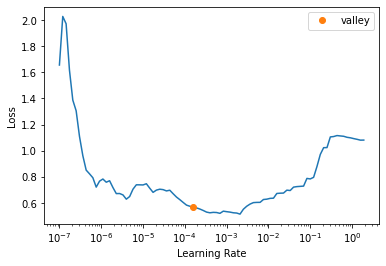

In [ ]:
tuner.lr_find()

It recommends a learning rate of around 1e-4, so we will use that.

In [ ]:
lr = 1e-4

Let's look at the documentation for `tune`:

In [ ]:
show_doc(SequenceClassificationTuner.tune)

<h4 id="AdaptiveTuner.tune" class="doc_header"><code>AdaptiveTuner.tune</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L364" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.tune</code>(**`epochs`**:`int`, **`lr`**:`float`=*`None`*, **`strategy`**:`Strategy`=*`'fit_one_cycle'`*, **`callbacks`**:`list`=*`[]`*, **\*\*`kwargs`**)

Fine tune `self.model` for `epochs` with an `lr` and `strategy`



We can pass in a number of epochs, a learning rate, a strategy, and additional fastai callbacks to call.

Valid strategies live in the `Strategy` namespace class, and consist of:
- OneCycle (Also called the [One-Cycle Policy](https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle))
- [CosineAnnealing](https://docs.fast.ai/callback.schedule.html#Learner.fit_flat_cos)
- [SGDR](https://docs.fast.ai/callback.schedule.html#Learner.fit_sgdr)

In [ ]:
from adaptnlp import Strategy

In this tutorial we will train with the One-Cycle policy, as currently it is one of the best schedulers to use.

In [ ]:
tuner.tune(3, lr, strategy=Strategy.OneCycle)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.666750,0.434634,0.810000,0.820331,00:05
1,0.379166,0.414586,0.837500,0.831606,00:05
2,0.215855,0.444072,0.833750,0.828829,00:05


## Saving Model

Now that we have a trained model, let's save those weights away.

Calling `tuner.save` will save both the model and the tokenizer in the same format as how HuggingFace does:

In [ ]:
show_doc(SequenceClassificationTuner.save)

<h4 id="AdaptiveTuner.save" class="doc_header"><code>AdaptiveTuner.save</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L386" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.save</code>(**`save_directory`**)

Save a pretrained model to a `save_directory`

**Function Arguments**:
* `save_directory`: A folder to save our model to


In [ ]:
tuner.save('good_model')

'good_model'

## Performing Inference

There are two ways to get predictions, the first is with the `.predict` method in our `tuner`. This is great for if you just finished training and want to see how your model performs on some new data!
The other method is with AdaptNLP's inference API, which we will show afterwards

### In Tuner

First let's write a sentence to test with

In [ ]:
sentence = "This movie was horrible! Hugh Jackman is a terrible actor"

And then predict with it:

In [ ]:
show_doc(SequenceClassificationTuner.predict)

<h4 id="SequenceClassificationTuner.predict" class="doc_header"><code>SequenceClassificationTuner.predict</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L272" class="source_link" style="float:right">[source]</a></h4>

> <code>SequenceClassificationTuner.predict</code>(**`text`**:`Union`\[`List`\[`str`\], `str`\], **`bs`**:`int`=*`64`*, **`detail_level`**:`DetailLevel`=*`'low'`*)

Predict some `text` for sequence classification with the currently loaded model

**Function Arguments**:
* `text` (`Union[List[str], str]`): Some text or list of texts to do inference with
* `bs` (`int`): A batch size to use for multiple texts
* `detail_level` (`DetailLevel `): A detail level to return on the predictions


In [ ]:
tuner.predict(sentence)

{'predictions': ['negative'],
 'probs': tensor([[0.9875, 0.0125]]),
 'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor']}

### With the Inference API

Next we will use the `EasySequenceClassifier` class, which AdaptNLP offers:

In [ ]:
from adaptnlp import EasySequenceClassifier

We simply construct the class:

In [ ]:
classifier = EasySequenceClassifier()

And call the `tag_text` method, passing in the sentence, the location of our saved model, and some names for our classes:

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path='good_model',
    class_names=['negative', 'positive']
)

2021-07-28 16:00:56,358 loading file good_model


{'predictions': ['negative'],
 'probs': tensor([[0.9875, 0.0125]]),
 'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor']}

And we got the exact same output and probabilities!

There are also different levels of predictions we can return (which is also the same with our earlier `predict` call).

These live in a namespace `DetailLevel` class, with a few examples below:

In [ ]:
from adaptnlp import DetailLevel

In [ ]:
DetailLevel.Low

'low'

While some Easy modules will not return different items at each level, most will return only a few specific outputs at the Low level, and everything possible at the High level:

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.Low
)

{'predictions': ['NEGATIVE'],
 'probs': tensor([[0.9875, 0.0125]]),
 'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor']}

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.Medium
)

{'classes': ['NEGATIVE', 'POSITIVE'],
 'pairings': OrderedDict([('This movie was horrible! Hugh Jackman is a terrible actor',
               tensor([0.9875, 0.0125]))]),
 'predictions': ['NEGATIVE'],
 'probs': tensor([[0.9875, 0.0125]]),
 'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor']}

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.High
)

{'classes': ['NEGATIVE', 'POSITIVE'],
 'pairings': OrderedDict([('This movie was horrible! Hugh Jackman is a terrible actor',
               tensor([0.9875, 0.0125]))]),
 'predictions': ['NEGATIVE'],
 'probs': tensor([[0.9875, 0.0125]]),
 'sentences': [Sentence: "This movie was horrible ! Hugh Jackman is a terrible actor"   [− Tokens: 11  − Sentence-Labels: {'sc': [NEGATIVE (0.9875), POSITIVE (0.0125)]}]]}